AutoGluon - Predicción de ventas (tn) por producto para febrero 2020

In [35]:
# 📦 1. Importar librerías
import pandas as pd

In [36]:
# 💬 Instalar AutoGluon si es necesario
#%pip install autogluon.timeseries

from autogluon.timeseries import TimeSeriesPredictor, TimeSeriesDataFrame
from sklearn.preprocessing import StandardScaler

In [37]:
# 📄 2. Cargar datasets
df_sellin = pd.read_csv("../data/sell-in.txt", sep="\t")
df_productos = pd.read_csv("../data/tb_productos.txt", sep="\t")

In [38]:
# 📄 Leer lista de productos a predecir
with open("../data/product_id_apredecir201912.txt", "r") as f:
    product_ids = [int(line.strip()) for line in f if line.strip().isdigit()]

In [39]:
# 🧹 3. Preprocesamiento
# Convertir periodo a datetime
df_sellin['timestamp'] = pd.to_datetime(df_sellin['periodo'], format='%Y%m')

In [40]:
# Filtrar hasta dic 2019 y productos requeridos
df_filtered = df_sellin[
    (df_sellin['timestamp'] <= '2019-12-01') &
    (df_sellin['product_id'].isin(product_ids))
]

In [41]:
# Agregar tn por periodo, cliente y producto
df_grouped = df_filtered.groupby(['timestamp', 'customer_id', 'product_id'], as_index=False)['tn'].sum()

In [42]:
# Agregar tn total por periodo y producto
df_monthly_product = df_grouped.groupby(['timestamp', 'product_id'], as_index=False)['tn'].sum()

In [43]:
# Agregar columna 'item_id' para AutoGluon
df_monthly_product['item_id'] = df_monthly_product['product_id']

In [44]:
# Crear características de lag y rolling
for lag in [1, 3, 6, 12]:
    df_monthly_product[f'tn_lag_{lag}'] = df_monthly_product.groupby('product_id')['tn'].shift(lag)

df_monthly_product['tn_rolling_mean_3'] = df_monthly_product.groupby('product_id')['tn'].shift(1).rolling(window=3).mean()
df_monthly_product['tn_rolling_std_3'] = df_monthly_product.groupby('product_id')['tn'].shift(1).rolling(window=3).std()

In [45]:
# Incorporar características estáticas de tb_productos
df_monthly_product = df_monthly_product.merge(df_productos, on='product_id', how='left')

# Normalizar características numéricas
scaler = StandardScaler()
numeric_cols = ['tn_lag_1', 'tn_lag_3', 'tn_lag_6', 'tn_lag_12', 'tn_rolling_mean_3', 'tn_rolling_std_3']
df_monthly_product[numeric_cols] = scaler.fit_transform(df_monthly_product[numeric_cols].fillna(0))

In [46]:
df_monthly_product

,timestamp,product_id,tn,item_id,tn_lag_1,tn_lag_3,tn_lag_6,tn_lag_12,tn_rolling_mean_3,tn_rolling_std_3,cat1,cat2,cat3,brand,sku_size
0,2017-01-01,20001,934.77222,20001,-0.404361,-0.391227,-0.369555,-0.322445,-0.433534,-0.303098,HC,ROPA LAVADO,Liquido,ARIEL,3000
1,2017-01-01,20002,550.15707,20002,-0.404361,-0.391227,-0.369555,-0.322445,-0.433534,-0.303098,HC,ROPA LAVADO,Liquido,LIMPIEX,3000
2,2017-01-01,20003,1063.45835,20003,-0.404361,-0.391227,-0.369555,-0.322445,-0.433534,-0.303098,FOODS,ADEREZOS,Mayonesa,NATURA,475
3,2017-01-01,20004,555.91614,20004,-0.404361,-0.391227,-0.369555,-0.322445,-0.433534,-0.303098,FOODS,ADEREZOS,Mayonesa,NATURA,240
4,2017-01-01,20005,494.27011,20005,-0.404361,-0.391227,-0.369555,-0.322445,-0.433534,-0.303098,FOODS,ADEREZOS,Mayonesa,NATURA,120
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22677,2019-12-01,21263,0.01270,21263,-0.404105,-0.391136,-0.369472,-0.321898,-0.433281,-0.303044,PC,CABELLO,SHAMPOO,VICHY,250
22678,2019-12-01,21265,0.05007,21265,-0.403841,-0.391089,-0.369126,-0.322445,-0.433178,-0.302692,PC,PIEL1,CUIDADO ESPECIAL,LANCOME,32
22679,2019-12-01,21266,0.05121,21266,-0.403832,-0.390996,-0.369116,-0.322445,-0.433064,-0.302720,PC,PIEL1,CUIDADO ESPECIAL,LANCOME,32
22680,2019-12-01,21267,0.01569,21267,-0.404042,-0.391079,-0.369062,-0.322445,-0.433041,-0.302809,PC,PIEL1,Cara,NIVEA,250


In [47]:
# df_prod_static = (
#     df_productos
#     .rename(columns={'product_id': 'item_id'})
#     .drop_duplicates(subset=['item_id'])
# )  # dejamos item_id como columna

ts_data = TimeSeriesDataFrame.from_data_frame(
    df_monthly_product,
    id_column='item_id',
    timestamp_column='timestamp',
    # static_features_df=df_prod_static
)


# # ⏰ 4. Crear TimeSeriesDataFrame
# ts_data = TimeSeriesDataFrame.from_data_frame(
#     df_monthly_product,
#     id_column='item_id',
#     timestamp_column='timestamp'
# )

In [48]:
# # Completar valores faltantes
ts_data = ts_data.fill_missing_values()

In [ ]:
predictor = TimeSeriesPredictor(
    prediction_length=2,
    target='tn',
    freq='MS',
    eval_metric='WQL'
)

predictor.fit(
    train_data=ts_data,
    num_val_windows=2,
    time_limit=60*60
)

Beginning AutoGluon training... Time limit = 3600s
AutoGluon will save models to 'c:\Users\leona\source\repos\lab3\notebooks\AutogluonModels\ag-20250713_235542'
=================== System Info ===================
AutoGluon Version:  1.3.1
Python Version:     3.10.17
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.26100
CPU Count:          12
GPU Count:          0
Memory Avail:       9.25 GB / 31.71 GB (29.2%)
Disk Space Avail:   203.77 GB / 952.62 GB (21.4%)

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': WQL,
 'freq': 'MS',
 'hyperparameters': 'default',
 'known_covariates_names': [],
 'num_val_windows': 2,
 'prediction_length': 1,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': False,
 'target': 'tn',
 'time_limit': 3600,
 'verbosity': 2}

train_data with frequency 'IRREG' has been resampled to frequency 'MS'.
Provided t

KeyboardInterrupt: 

In [ ]:
# 3.1) Sólo data como argumento
future_template = predictor.make_future_data_frame(ts_data)

# 3.2) Covariables “a mano”
future_rows = []
for item_id in product_ids:
    last = df_monthly_product[df_monthly_product['item_id']==item_id].iloc[-1]
    future_rows.append({
        'item_id': item_id,
        'timestamp': pd.Timestamp('2020-02-01'),
        'month':  2,
        'year':   2020,
        'tn_lag_1':          last['tn_lag_1'],
        'tn_lag_3':          last['tn_lag_3'],
        'tn_lag_6':          last['tn_lag_6'],
        'tn_lag_12':         last['tn_lag_12'],
        'tn_rolling_mean_3': last['tn_rolling_mean_3'],
        'tn_rolling_std_3':  last['tn_rolling_std_3'],
    })
df_future_covars = pd.DataFrame(future_rows)

# 3.3) Merge plantilla + covariables
future_covars = future_template.merge(
    df_future_covars,
    on=['item_id','timestamp'],
    how='left'
)

# 3.4) A TimeSeriesDataFrame
ts_future_covars = TimeSeriesDataFrame.from_data_frame(
    future_covars,
    id_column='item_id',
    timestamp_column='timestamp'
).fill_missing_values(method='ffill', value=0)

In [27]:
# # 🔮 6. Generar predicción
# forecast = predictor.predict(ts_data)

# 4) Predecir
forecast = predictor.predict(
    data=ts_data,
    known_covariates=ts_future_covars
)

data with frequency 'IRREG' has been resampled to frequency 'MS'.
Model not specified in predict, will default to the model with the best validation score: WeightedEnsemble


In [29]:
forecast

,,mean,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9
item_id,timestamp,,,,,,,,,,
20001,2020-01-01,1212.043773,924.289769,1029.889665,1081.908878,1135.102923,1213.058614,1271.029112,1329.369718,1403.680534,1538.084259
20002,2020-01-01,995.504510,658.881344,778.742968,848.317428,911.199812,995.238444,1058.698980,1117.454908,1178.462553,1336.393789
20003,2020-01-01,693.969779,466.748053,563.920086,594.939069,645.669548,694.906012,735.096813,799.676343,830.865341,927.600116
20004,2020-01-01,513.709401,347.262645,416.440177,435.523129,476.650569,514.102137,543.889553,587.039763,610.750308,681.372567
20005,2020-01-01,481.020561,324.469371,390.199557,409.816743,447.308256,481.004219,514.404103,555.471935,579.374177,648.488994
...,...,...,...,...,...,...,...,...,...,...,...
20962,2020-01-01,2.721117,1.227276,1.764917,2.104140,2.445453,2.720947,2.995646,3.283226,3.716578,4.469777
20975,2020-01-01,2.356415,0.868498,1.388695,1.767358,2.103420,2.359896,2.647165,2.942618,3.407111,4.129011
20995,2020-01-01,2.243212,0.910318,1.385815,1.693822,2.009455,2.242631,2.478940,2.772446,3.193287,3.818681


In [28]:
predictor.leaderboard(ts_data)

data with frequency 'IRREG' has been resampled to frequency 'MS'.
Additional data provided, testing on additional data. Resulting leaderboard will be sorted according to test score (`score_test`).


,model,score_test,score_val,pred_time_test,pred_time_val,fit_time_marginal,fit_order
0,WeightedEnsemble,-0.174852,-0.168365,10.900603,2.090106,2.212314,13
1,TemporalFusionTransformer,-0.175259,-0.171659,0.817792,0.611692,556.259888,9
2,DirectTabular,-0.191891,-0.184596,0.249110,0.182381,25.083344,3
3,PatchTST,-0.206176,-0.184622,0.609439,0.304861,138.263201,11
4,TiDE,-0.207206,-0.192520,1.063796,0.669463,309.917634,12
5,ChronosFineTuned[bolt_small],-0.215619,-0.191318,2.004168,0.663951,522.278884,8
6,ChronosZeroShot[bolt_base],-0.234320,-0.201927,6.027545,3.605805,10.299376,7
7,AutoETS,-0.240269,-0.206487,3.763367,2.980475,3.145687,6
8,DynamicOptimizedTheta,-0.252091,-0.218670,8.524455,0.609729,2.480548,5
9,RecursiveTabular,-0.260900,-0.220066,0.144227,0.066297,2.305006,2


data with frequency 'IRREG' has been resampled to frequency 'MS'.


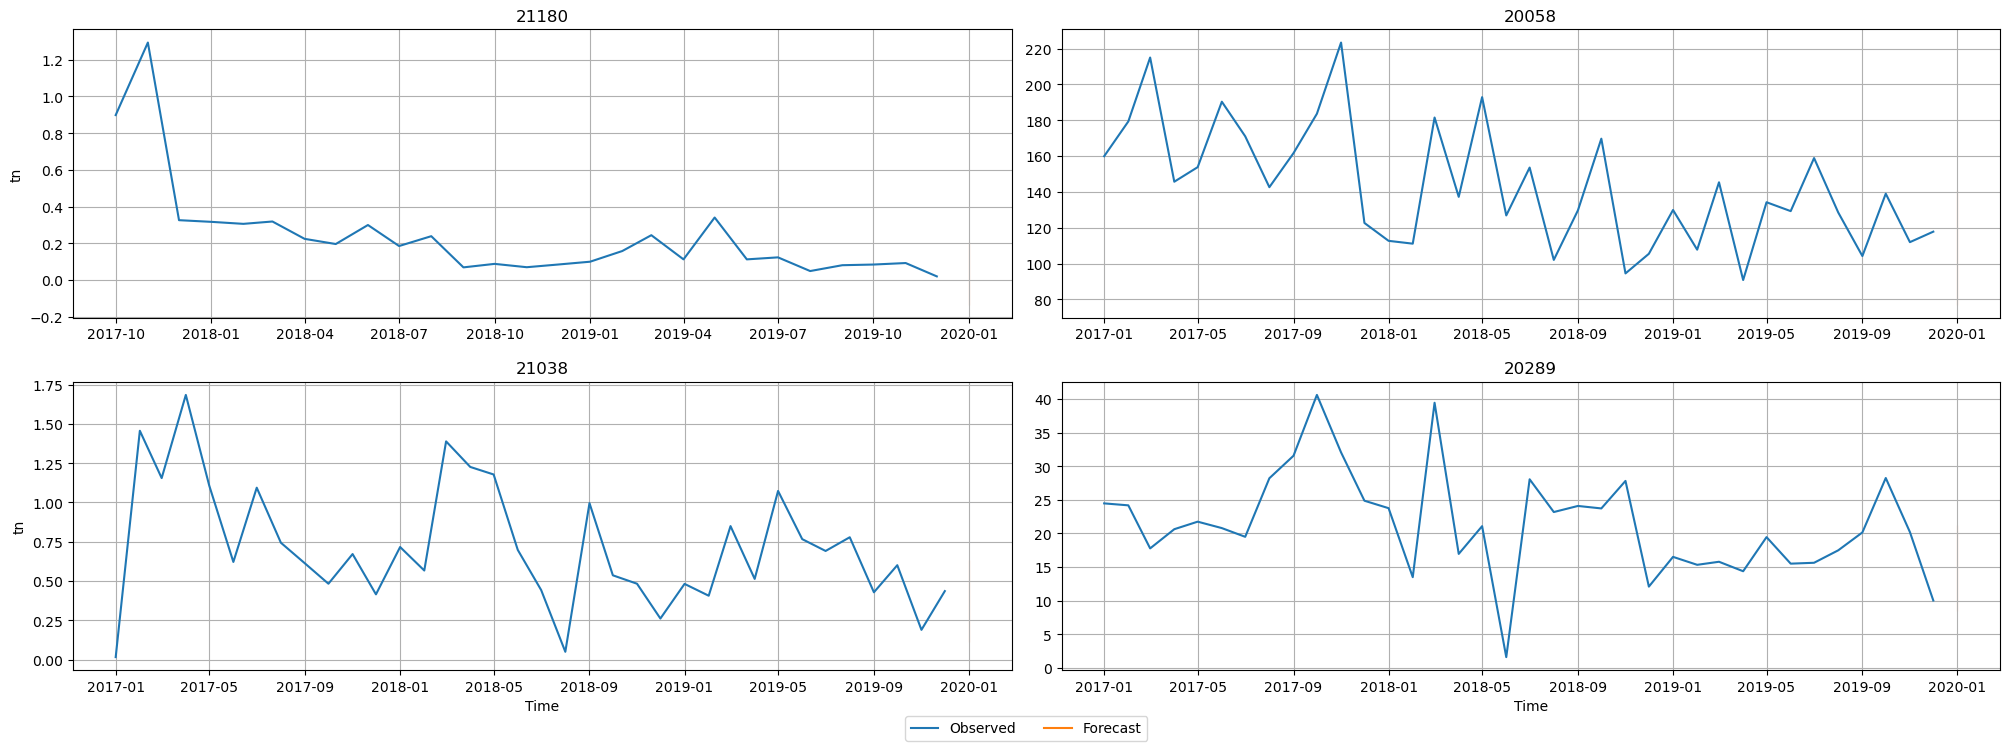

In [31]:
predictor.plot(ts_data, forecast, quantile_levels=[0.1, 0.9], max_history_length=200, max_num_item_ids=4)

In [32]:
# Extraer predicción media y filtrar febrero 2020
forecast_mean = forecast['mean'].reset_index()
print(forecast_mean.columns)

Index(['item_id', 'timestamp', 'mean'], dtype='object')


In [33]:
# Tomar solo item_id y la predicción 'mean'
resultado = forecast['mean'].reset_index()[['item_id', 'mean']]
resultado.columns = ['product_id', 'tn']

# Filtrar solo febrero 2020
resultado = forecast['mean'].reset_index()
resultado = resultado[resultado['timestamp'] == '2020-02-01']

# Renombrar columnas
resultado = resultado[['item_id', 'mean']]
resultado.columns = ['product_id', 'tn']


In [34]:
resultado

,product_id,tn


In [ ]:
# 💾 7. Guardar archivo
resultado.to_csv("../data/autogluon_202002_lhv10.csv", index=False)
resultado.head()

,product_id,tn
1,20001,1303.226827
3,20002,1066.312475
5,20003,700.919699
7,20004,522.597608
9,20005,512.527806


In [ ]:
# from autogluon.common import space

# # ⚙️ 5. Definir y entrenar predictor
# predictor = TimeSeriesPredictor(
#     prediction_length=2,
#     target='tn',
#     eval_metric="MASE",
#     freq='MS'  # Frecuencia mensual (Month Start), 
# )

# predictor.fit(
#     ts_data,
#     presets="best_quality",    
#     hyperparameters={
#         "DeepAR": {
#             "hidden_size": space.Int(20, 100),
#             "dropout_rate": space.Categorical(0.1, 0.3),
#         },
#         "Theta": [
#             {"decomposition_type": "additive"},
#             {"seasonal_period": 1},
#         ],
#         "Chronos": [
#             {
#                 "model_path": "bolt_small", 
#                 "ag_args": {"name_suffix": "ZeroShot"}
#             },
#             {
#                 "model_path": "bolt_small", 
#                 "fine_tune": True, 
#                 "ag_args": {"name_suffix": "FineTuned"}
#             },
#             {
#                 "model_path": "bolt_small",
#                 "covariate_regressor": "CAT",
#                 "target_scaler": "standard",
#                 "ag_args": {"name_suffix": "WithRegressor"},
#             },            
#         ]        
#     },
#     enable_ensemble=True,
#     time_limit=3600
# )

Beginning AutoGluon training... Time limit = 3600s
AutoGluon will save models to 'c:\Users\leona\source\repos\lab3\notebooks\AutogluonModels\ag-20250703_023005'
=================== System Info ===================
AutoGluon Version:  1.3.1
Python Version:     3.10.17
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.26100
CPU Count:          12
GPU Count:          0
Memory Avail:       8.57 GB / 31.71 GB (27.0%)
Disk Space Avail:   176.32 GB / 952.62 GB (18.5%)
Setting presets to: best_quality

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': MASE,
 'freq': 'MS',
 'hyperparameters': {'DeepAR': {},
                     'Theta': [{'decomposition_type': 'additive'},
                               {'seasonal_period': 1}]},
 'known_covariates_names': [],
 'num_val_windows': 2,
 'prediction_length': 2,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_m